# Clamped semi-cylindrical Naghdi shell under point load

This demo program solves the nonlinear Naghdi shell equations for a semi-cylindrical shell loaded by a point force. This problem is a standard reference for testing shell finite element formulations, see [1]. The numerical locking issue is cured using enriched finite element including cubic bubble shape functions and Partial Selective Reduced Integration [2].

It is assumed the reader understands most of the basic functionality of the new FEniCSx Project.

This demo then illustrates how to:

- Define and solve a nonlinear Naghdi shell problem with a curved stress-free configuration given as analytical expression in terms of two curvilinear coordinates.
- Use the PSRI approach to simultaneously cure shear- and membrane-locking issues.

We begin by importing the necessary functionality from DOLFINx, UFL and PETSc.

In [1]:
import numpy as np

import dolfinx
import ufl
from basix.ufl import blocked_element, element, enriched_element, mixed_element
from dolfinx.fem import Function, functionspace, dirichletbc, Expression, locate_dofs_topological
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import grad, inner, split
from dolfinx import plot
from dolfinx.nls.petsc import NewtonSolver
from mpi4py import MPI
from petsc4py import PETSc
from tqdm import tqdm
import pyvista

# Simulation setup

In [3]:
nex = int(64)
ney = int(32)

PSRI_control = True
plot_control = True

ele_dict = {0 : "tri_P1",
            1 : "tri_P2",
            2 : "tri_P2B3",
            3 : "qua_P1",
            4 : "qua_P2",
            5 : "qua_S2",}

ele_index = 5
ele_type = ele_dict[ele_index]


if ele_type == "tri_P2B3":
    cell_type = CellType.triangle
    
elif ele_type == "tri_P2":
    cell_type = CellType.triangle

elif ele_type == "tri_P1":
    cell_type = CellType.triangle
    
elif ele_type == "qua_P2":
    cell_type = CellType.quadrilateral
    
elif ele_type == "qua_P1":
    cell_type = CellType.quadrilateral

elif ele_type == "qua_S2":
    cell_type = CellType.quadrilateral

In [4]:
from pathlib import Path

if not PSRI_control:
    results_folder = Path(f"results/nonlinear_Naghdi/non_PSRI/semi_cylinder/{nex}_{ney}_{ele_type}")
else:
    results_folder = Path(f"results/nonlinear_Naghdi/semi_cylinder/{nex}_{ney}_{ele_type}")

results_folder.mkdir(exist_ok=True, parents=True)

if plot_control:
    pyvista.start_xvfb()

# Mesh

We consider a semi-cylindrical shell of radius $r$ and axis length $L$. The shell is made of a linear elastic isotropic homogeneous
material with Young modulus $E$ and Poisson ratio $\nu$. The
(uniform) shell thickness is denoted by $t$.
The Lamé moduli $\lambda$, $\mu$ are introduced to write later
the 2D constitutive equation in plane-stress:

In [5]:
r = 1.016 
L = 3.048 
E, nu = 2.0685E7, 0.3 
mu = E/(2.0*(1.0 + nu)) 
lmbda = 2.0*mu*nu/(1.0 - 2.0*nu) 
t = 0.03 

The midplane of the initial (stress-free) configuration $\vec{\phi_0}$ of the shell is given in the form of an analytical expression:

$$
\vec{\phi}_0(\xi_1, \xi_2) \subset \mathbb{R}³
$$

where $\xi_1 \in [-\pi/2, \pi/2]$ and $\xi_2 \in [0, L]$ are the curvilinear coordinates. In this case, they represent the angular and axial coordinates, respectively.

We generate a mesh in the $(\xi_1, \xi_2)$ space with triangular elements

In [6]:
mesh = create_rectangle(MPI.COMM_WORLD, np.array([[-np.pi / 2, 0], [np.pi / 2, L]]), 
                        [nex, ney], cell_type)

tdim = mesh.topology.dim
fdim = tdim - 1

cell = mesh.basix_cell()
P1 = element("Lagrange", cell, degree=1)
P2 = element("Lagrange", cell, degree=2)
S2 = element("Serendipity", cell, degree=2)
B3 = element("Bubble", cell, degree=3)

## Plot mesh

In [6]:
topology, cell_types, geometry = plot.vtk_mesh(mesh, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid, show_edges=True)
plotter.show_grid()
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"mesh_rank{mesh.comm.rank}.png")

plotter.close()

Widget(value='<iframe src="http://localhost:37671/index.html?ui=P_0x7f4334199460_0&reconnect=auto" class="pyvi…

# Initial shape

We provide the analytical expression of the initial shape as a `ufl` expression

In [7]:
x = ufl.SpatialCoordinate(mesh)
phi0_ufl = ufl.as_vector([r * ufl.sin(x[0]), x[1], r * ufl.cos(x[0])])

Given the analytical expression of midplane, we define the unit normal as below:
$$
\vec{n}  = \frac{\partial_1 \phi_0 \times \partial_2 \phi_0}{\| \partial_1 \phi_0 \times \partial_2 \phi_0 \|}
$$

In [8]:
def unit_normal(phi):
    n = ufl.cross(phi.dx(0), phi.dx(1))
    return n/ufl.sqrt(inner(n, n))

n0_ufl = unit_normal(phi0_ufl)

## Plot initial shape

We plot the initial shape and the unit normal by interpolating them in the 1st order Lagrange Finite Element space

In [8]:
# create a FEM interpolation of n0 and phi0
P1_d3_FS = functionspace(mesh, blocked_element(P1, shape = (3,)))

n0_P1_expr = Expression(n0_ufl, P1_d3_FS.element.interpolation_points())
n0_P1_func = Function(P1_d3_FS)
n0_P1_func.interpolate(n0_P1_expr)

phi0_P1_expr = Expression(phi0_ufl, P1_d3_FS.element.interpolation_points())
phi0_P1_func = Function(P1_d3_FS)
phi0_P1_func.interpolate(phi0_P1_expr)

In [13]:
topology, cell_types, geometry = plot.vtk_mesh(P1_d3_FS)

geometry_phi0_P1 = phi0_P1_func.x.array.reshape((geometry.shape[0], len(phi0_P1_func)))
geometry_n0_P1 = n0_P1_func.x.array.reshape((geometry.shape[0], len(n0_P1_func)))

grid_phi0_P1 = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi0_P1)
grid_phi0_P1["n0"] = geometry_n0_P1
glyphs = grid_phi0_P1.glyph(orient="n0", factor=0.2)


plotter = pyvista.Plotter(off_screen = True)
plotter.add_mesh(grid_phi0_P1, style="wireframe", color="k")
plotter.add_mesh(glyphs,  show_scalar_bar=True, scalar_bar_args={"vertical": True})
plotter.show_grid()
plotter.show_axes_all()
plotter.enable_parallel_projection()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/f"initial_shape_rank{mesh.comm.rank}.png")
    
plotter.close()

Widget(value='<iframe src="http://localhost:37671/index.html?ui=P_0x7f43c6c076b0_0&reconnect=auto" class="pyvi…

We define a local orthonormal frame $\{\vec{t}_{01}, \vec{t}_{02}, \vec{n}\}$ of the initial configuration $\phi_0$ by rotating the global Cartesian basis $\vec{e}_i$ with a rotation matrix $\mathbf{R}_0$:

$$
\vec{t}_{0i} = \mathbf{R}_0 \vec{e}_i , \quad \vec{n} = \vec{t}_{03},
$$

A convienent choice of $\vec{t}_{01}$ and $\vec{t}_{02}$ (when $\vec{n} \nparallel \vec{e}_2 $) could be:
$$
\vec{t}_{01} = \frac{\vec{e}_2 \times \vec{n}}{\| \vec{e}_2 \times \vec{n}\|} \\
\vec{t}_{02} =   \vec{n} \times \vec{t}_{01}
$$


The corresponding rotation matrix $\mathbf{R}_0$:
$$
\mathbf{R}_0 = [\vec{t}_{01}; \vec{t}_{02}; \vec{n}]
$$


# Director

In [9]:
def tangent_1(n):
    e2 = ufl.as_vector([0, 1, 0])
    t1 = ufl.cross(e2, n)
    t1 = t1/ufl.sqrt(inner(t1, t1))
    return t1

def tangent_2(n, t1):
    t2 = ufl.cross(n, t1)
    t2 = t2/ufl.sqrt(inner(t2, t2))
    return t2

# the analytical expression of t1 and t2
t1_ufl = tangent_1(n0_ufl)
t2_ufl = tangent_2(n0_ufl, t1_ufl)

# the analytical expression of R0
def rotation_matrix(t1, t2, n):
    R = ufl.as_matrix([[t1[0], t2[0], n[0]], 
                       [t1[1], t2[1], n[1]], 
                       [t1[2], t2[2], n[2]]])
    return R

R0_ufl = rotation_matrix(t1_ufl, t2_ufl, n0_ufl)

The kinematics of the Nadghi shell model is defined by the following vector fields :
- $\vec{\phi}$: the position of the midplane in the deformed configuration, or equivalently, the displacement $\vec{u} = \vec{\phi} - \vec{\phi}_0$
- $\vec{d}$: the director, a unit vector giving the orientation of fiber at the midplane. (not necessarily normal to the midsplane because of shears)

According to [3], the director $\vec{d}$ in the deformed configuration can be parameterized with two successive rotation angles $\theta_1, \theta_2$

$$
\vec{t}_i = \mathbf{R} \vec{e}_i, \quad \mathbf{R}  = \text{exp}[\theta_1 \hat{\mathbf{t}}_1] \text{exp}[\theta_2 \hat{\mathbf{t}}_{02}] \mathbf{R}_0 
$$

The rotation matrix $\mathbf{R}$ represents three successive rotations:
- First one: the initial rotation matrix $\mathbf{R}_0$
- Second one :$\text{exp}[\theta_2 \hat{\mathbf{t}}_{02}]$ rotates a vector about the axis $\vec{t}_{02}$ of $\theta_2$ angle; 
- Third one : $\text{exp}[\theta_1 \hat{\mathbf{t}}_1]$ rotates a vector about the axis $\vec{t}_{1}$ of $\theta_1$ angle, and $\vec{t}_1 = \text{exp}[\theta_2 \hat{\mathbf{t}}_{02}] \vec{t}_{01}$

The rotation matrix $\mathbf{R}$ on the other hand is equivalent to rotate around the fixed axis $\vec{e}_1$ and $\vec{e}_2$ (Proof see [3]):
$$
\mathbf{R} = \mathbf{R}_0 \text{exp}[\theta_2 \hat{\mathbf{e}}_{2}] \text{exp}[\theta_1 \hat{\mathbf{e}}_1]
$$

Therefore, the director $\vec{d}$ is updated with $(\theta_1, \theta_2)$ by:

$$
\vec{d} =\mathbf{R} \vec{e}_3 = \mathbf{R}_0 \vec{\Lambda}_3, \quad \vec{\Lambda}_3 = [\sin(\theta_2)\cos(\theta_1), -\sin(\theta_1), \cos(\theta_2)\cos(\theta_1)]^\text{T}
$$

Note: the above formular becomes singular when $\theta_1 = \pm \pi/2, ...$, (See Chapter 4.2.1 in [3] for details)

In [10]:
# Update the director with two successive elementary rotations

def director(R0, theta):
    Lm3 = ufl.as_vector([ufl.sin(theta[1])*ufl.cos(theta[0]), -ufl.sin(theta[0]), ufl.cos(theta[1])*ufl.cos(theta[0])])
    d = ufl.dot(R0, Lm3)
    return d

# Shell element

In our 5-parameter Naghdi shell model the configuration of the shell is assigned by:
- the 3-component vector field $\vec{u}$ representing the displacement with respect to the initial configuration $\vec{\phi}_0$ 
- the 2-component vector field $\vec{\theta}$ representing the angle variation of the director $\vec{d}$ with respect to initial unit normal $\vec{n}$

Following [1], we use a $[P_2 + B_3]³$ element for $\vec{u}$ and a $[P_2]²$ element for $\vec{\theta}$ and collect them in the state vector $\vec{q} = [\vec{u}, \vec{\theta}]$:

In [11]:
if ele_type == "tri_P2B3":
    P2B3 = enriched_element([P2, B3])
    naghdi_shell_element = mixed_element(
        [blocked_element(P2B3, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "tri_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
        )

elif ele_type == "tri_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )
    
elif ele_type == "qua_P2":
    naghdi_shell_element = mixed_element(
        [blocked_element(P2, shape=(3,)), blocked_element(P2, shape=(2,))]
    )
elif ele_type == "qua_P1":
    naghdi_shell_element = mixed_element(
        [blocked_element(P1, shape=(3,)), blocked_element(P1, shape=(2,))]
    )

elif ele_type == "qua_S2":
    naghdi_shell_element = mixed_element(
        [blocked_element(S2, shape=(3,)), blocked_element(S2, shape=(2,))]
    )
    
naghdi_shell_FS = functionspace(mesh, naghdi_shell_element)

Then, we define `Function`, `TrialFunction` and `TestFunction` objects to express the variational forms and we split the mixed function into two subfunctions for displacement and rotation.

In [12]:
q_func = Function(naghdi_shell_FS) # current configuration
q_trial = ufl.TrialFunction(naghdi_shell_FS)
q_test = ufl.TestFunction(naghdi_shell_FS)

u_func, theta_func = split(q_func) # current displacement and rotation

# Shell model

We calculate the deformation gradient and the first, second fundamental forms:

- Deformation gradient $\mathbf{F}$
$$
\mathbf{F} = \nabla \vec{\phi} \quad  (F_{ij} = \frac{\partial \phi_i}{\partial \xi_j}); \quad \vec{\phi} = \vec{\phi}_0 + 
\vec{u} \quad i = 1,2,3; j = 1,2
$$

- Metric tensor $\mathbf{a} \in \mathbb{S}^2_+$ and curvature tensor $\mathbf{b} \in \mathbb{S}^2$ (First and second fundamental form)
$$
\mathbf{a} = {\nabla \vec{\phi}} ^{T} \nabla \vec{\phi} \\
\mathbf{b} = -\frac{1}{2}({\nabla \vec{\phi}} ^{T} \nabla \vec{d} + {\nabla \vec{d}} ^{T} \nabla \vec{\phi})

$$

In the initial configuration, $\vec{d} = \vec{n}$, $\vec{\phi} = \vec{\phi}_0$, the conresponding initial tensors are $\mathbf{a}_0$, $\mathbf{b}_0$

In [13]:
# current deformation gradient 
F = grad(u_func) + grad(phi0_ufl) 

# current director
d = director(R0_ufl, theta_func)

# initial metric and curvature tensor a0 and b0
a0_ufl = grad(phi0_ufl).T * grad(phi0_ufl)
b0_ufl = 0.5*( grad(phi0_ufl).T * grad(n0_ufl) + grad(n0_ufl).T * grad(phi0_ufl) )

We define strain measures of the Naghdi shell model:
- Membrane strain tensor $\boldsymbol{\varepsilon}(\vec{u})$

$$
\boldsymbol{\varepsilon} (\vec{u})= \frac{1}{2} \left ( \mathbf{a}(\vec{u}) - \mathbf{a}_0 \right)
$$

- Bending strain tensor $\boldsymbol{\kappa}(\vec{u}, \vec{\theta})$ 

$$
\boldsymbol{\kappa}(\vec{u}, \vec{\theta}) = \mathbf{b}(\vec{u}, \vec{\theta}) - \mathbf{b}_0
$$

- transverse shear strain vector $\vec{\gamma}(\vec{u}, \vec{\theta})$ 

$$
\begin{aligned}
\vec{\gamma}(\vec{u}, \vec{\theta}) & = {\nabla \vec{\phi}(\vec{u})}^T \vec{d}(\vec{\theta}) - {\nabla\vec{\phi}_0}^T \vec{n} \\
& = {\nabla \vec{\phi}(\vec{u})}^T \vec{d}(\vec{\theta}) \quad \text{if zero initial shears}
\end{aligned}
$$


In [14]:
def epsilon(F):
    """Membrane strain"""
    return 0.5 * (F.T * F - a0_ufl)


def kappa(F, d):
    """Bending strain"""
    return 0.5 * (F.T * grad(d) + grad(d).T * F) - b0_ufl


def gamma(F, d):
    """Transverse shear strain"""
    return F.T * d

In curvilinear coordinates, the stiffness modulus of linear isotropic material is defined as:
- Membrane stiffness modulus $A^{\alpha\beta\sigma\tau}$, $D^{\alpha\beta\sigma\tau}$ (contravariant components)

$$
\frac{A^{\alpha\beta\sigma\tau}}t=12\frac{D^{\alpha\beta\sigma\tau}}{t^3}=\frac{2\lambda\mu}{\lambda+2\mu}a_0^{\alpha\beta}a_0^{\sigma\tau}+\mu(a_0^{\alpha\sigma}a_0^{\beta\tau}+a_0^{\alpha\tau}a_0^{\beta\sigma})
$$

- Shear stiffness modulus $S^{\alpha\beta}$ (contravariant components)

$$
\frac{S^{\alpha\beta}}t = \alpha_s \mu a_0^{\alpha\beta} , \quad \alpha_s = \frac{5}{6}: \text{shear factor}
$$

where $a_0^{\alpha\beta}$ is the contravariant components of the initial metric tensor $\mathbf{a}_0$ 

In [15]:
a0_contra_ufl = ufl.inv(a0_ufl)
j0_ufl = ufl.det(a0_ufl)

i,j,l,m = ufl.indices(4)  # noqa: E741
A_contra_ufl = ufl.as_tensor( ( ((2.0*lmbda*mu) / (lmbda + 2.0*mu)) * a0_contra_ufl[i,j]*a0_contra_ufl[l,m]
                + 1.0*mu* (a0_contra_ufl[i,l]*a0_contra_ufl[j,m] + a0_contra_ufl[i,m]*a0_contra_ufl[j,l]) )
                ,[i,j,l,m])

We define the resultant stress measures:

- Membrane stress tensor $\mathbf{N}$

$$
\mathbf{N} = \mathbf{A} : \boldsymbol{\varepsilon}
$$

- Bending stress tensor $\mathbf{M}$

$$
\mathbf{M} = \mathbf{D} : \boldsymbol{\kappa}
$$

- Shear stress vector $\vec{T}$

$$
\vec{T} = \mathbf{S} \cdot \vec{\gamma}
$$


In [16]:
N = ufl.as_tensor(t * A_contra_ufl[i,j,l,m] * epsilon(F)[l,m], [i,j])

M = ufl.as_tensor( (t**3 / 12.0) * A_contra_ufl[i,j,l,m]*kappa(F, d)[l,m], [i,j])

T = ufl.as_tensor( (t * mu *5.0 / 6.0) * a0_contra_ufl[i, j] * gamma(F, d)[j], [i])

We define elastic strain energy density $\psi_{m}$, $\psi_{b}$, $\psi_{s}$ for membrane, bending and shear, respectively.

$$
\psi_m = \frac{1}{2} \mathbf{N} : \boldsymbol{\varepsilon}; \quad
\psi_b = \frac{1}{2} \mathbf{M} : \boldsymbol{\kappa}; \quad
\psi_s = \frac{1}{2} \vec{T} \cdot \vec{\gamma}
$$

They are per unit surface in the initial configuration):

In [17]:
psi_m = 0.5*inner(N, epsilon(F))

psi_b = 0.5*inner(M, kappa(F, d))

psi_s = 0.5*inner(T, gamma(F, d))

# Weak form equation with PSRI

Shear and membrane locking is treated using the partial reduced selective integration proposed in Arnold and Brezzi [2].

We introduce a parameter $\alpha \in \mathbb{R}$ that splits the membrane and shear energy in the energy functional into a weighted sum of two parts:

$$
\begin{aligned}\Pi_{N}(u,\theta)&=\Pi^b(u_h,\theta_h)+\alpha\Pi^m(u_h)+(1-\alpha)\Pi^m(u_h)\\&+\alpha\Pi^s(u_h,\theta_h)+(1-\alpha)\Pi^s(u_h,\theta_h)-W_{\mathrm{ext}},\end{aligned}
$$

We apply reduced integration to the parts weighted by the factor $(1-\alpha)$

More details:
- Optimal choice $\alpha = \frac{t^2}{h^2}$, $h$ is the diameter of the cell
- Full integration : Gauss quadrature of degree 4 (6 integral points for triangle)
- Reduced integration : Gauss quadrature of degree 2 (3 integral points for triangle). 
    - While [1] suggests a 1-point reduced integration, we observed that this leads to spurious modes in the present case.



__More on lockings__:

As we can see in the definition of bending, membrane and shear stiffness modulus:
$$
\Pi ^ b \propto t^3, \quad \Pi^m \propto t, \quad \Pi^s \propto t
$$

when thickness $t$ is very small, $\Pi^b$ is much smaller than $\Pi^m$ and $\Pi^s$. In order to find the minimum of total energy functional, it is almost equivalent to require  $\Pi^m = \Pi^s = 0$. 

However, with common FEM discretizations, this requirement is too strong, the resulting solution of $\vec{u}_h, \vec{\theta}_h$ is very close to zero even at strong external forces, unless the mesh size is small compared with the thickness.

For example, we consider shear strain $\gamma = \nabla w - \theta$, with 1st order piecewise polynomal approximations $w_h$ and $\theta_h$. The only solution for $\gamma_h = \nabla w_h - \theta_h = 0$ is $w_h = 0, \theta_h = 0$

__More on reduced integration__:

With reduced integration, the new constraint is far less restrictive. It is now possible to have nonzero solutions $u_h, \theta_h $ for $\Pi^{m,r} = \Pi^{s,r} = 0$.

How reduced integration may threaten the stability of FEM, because of the existence of spurious zero-stiffness modes. In other words, there may exist nonzero solutions $\vec{q}_{nz}$ for all the three kinds of energy equal to zero: $\Pi^{b,r}(\vec{q}_{nz}) = \Pi^{m,r}(\vec{q}_{nz}) = \Pi^{s,r}(\vec{q}_{nz}) = 0$

In [18]:
if ele_type == "qua_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 3})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 3})
        
elif ele_type == "tri_P1":
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 1})
    
else:
    dx_f = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})
    if PSRI_control:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 2})
    else:
        dx_r = ufl.Measure('dx', domain=mesh, metadata={"quadrature_degree": 4})

# Calculate the factor alpha as a function of the mesh size h
h = ufl.CellDiameter(mesh)
alpha_FS = functionspace(mesh, element("DG", cell, 0))
alpha_expr = Expression(t**2 / h**2, alpha_FS.element.interpolation_points())
alpha = Function(alpha_FS)
alpha.interpolate(alpha_expr)

# Full integration part of the total elastic energy
Pi_PSRI = psi_b * ufl.sqrt(j0_ufl) * dx_f 
Pi_PSRI += alpha * psi_m * ufl.sqrt(j0_ufl) * dx_f
Pi_PSRI += alpha * psi_s * ufl.sqrt(j0_ufl) * dx_f

# Reduced integration part of the total elastic energy
Pi_PSRI += (1.0 - alpha) * psi_m * ufl.sqrt(j0_ufl) * dx_r
Pi_PSRI += (1.0 - alpha) * psi_s * ufl.sqrt(j0_ufl) * dx_r

# external work part (zero in this case)
W_ext = 0.0
Pi_PSRI -= W_ext

The residual and jacobian are the first and second order derivatives of the total potential energy, respectively

In [19]:
Residual = ufl.derivative(Pi_PSRI, q_func, q_test)
Jacobian = ufl.derivative(Residual, q_func, q_trial)

# Boundary conditions

Next, we prescribe the dirichlet boundary conditions:
- fully clamped boundary conditions on the top boundary ($\xi_2 = 0$):
    - $u_{1,2,3} = \theta_{1,2} = 0$

In [20]:
# clamped boundary condition

def clamped_boundary(x):
    return np.isclose(x[1], 0.0)

clamped_facets = locate_entities_boundary(mesh, fdim, clamped_boundary)

u_FS, _ = naghdi_shell_FS.sub(0).collapse()
theta_FS, _ = naghdi_shell_FS.sub(1).collapse()

# u1, u2, u3 = 0 on the clamped boundary
u_clamped = Function(u_FS) # default value is 0
clamped_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0), u_FS), fdim, clamped_facets)
bc_clamped_u = dirichletbc(u_clamped, clamped_dofs_u, naghdi_shell_FS.sub(0))

# theta1, theta2 = 0 on the clamped boundary
theta_clamped = Function(theta_FS) # default value is 0
clamped_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1), theta_FS), fdim, clamped_facets)
bc_clamped_theta = dirichletbc(theta_clamped, clamped_dofs_theta, naghdi_shell_FS.sub(1))

- symmetry boundary conditions on the left and right side ($\xi_1 = \pm \pi/2$):
    - $u_3 = \theta_2 = 0$

In [21]:
# symmetry boundary condition

def symm_boundary(x):
    return np.isclose(abs(x[0]), np.pi/2)

symm_facets = locate_entities_boundary(mesh, fdim, symm_boundary)

# u3 = 0 on the symmetry boundary
symm_dofs_u = locate_dofs_topological((naghdi_shell_FS.sub(0).sub(2), u_FS.sub(2)), fdim, symm_facets)
bc_symm_u = dirichletbc(u_clamped, symm_dofs_u, naghdi_shell_FS.sub(0).sub(2))

# theta2 = 0 on the symmetry boundary
symm_dofs_theta = locate_dofs_topological((naghdi_shell_FS.sub(1).sub(1), theta_FS.sub(1)), fdim, symm_facets)
bc_symm_theta = dirichletbc(theta_clamped, symm_dofs_theta, naghdi_shell_FS.sub(1).sub(1))

# all together
bcs = [bc_clamped_u, bc_clamped_theta, bc_symm_u, bc_symm_theta]

# Point source

The loading is exerted by a point force along the $z$ direction applied at the midpoint of the bottom boundary. Since `PointSource` function is not available by far in new FEniCSx, we achieve the same functionality according to the reply in [4]

In [22]:
def compute_cell_contributions(V, points):
    # Determine what process owns a point and what cells it lies within
    mesh = V.mesh
    _, _, owning_points, cells = dolfinx.cpp.geometry.determine_point_ownership(
        mesh._cpp_object, points, 1e-6)
    owning_points = np.asarray(owning_points).reshape(-1, 3)

    # Pull owning points back to reference cell
    mesh_nodes = mesh.geometry.x
    cmap = mesh.geometry.cmaps[0]
    ref_x = np.zeros((len(cells), mesh.geometry.dim),
                     dtype=mesh.geometry.x.dtype)
    for i, (point, cell) in enumerate(zip(owning_points, cells)):
        geom_dofs = mesh.geometry.dofmap[cell]
        ref_x[i] = cmap.pull_back(point.reshape(-1, 3), mesh_nodes[geom_dofs])

    # Create expression evaluating a trial function (i.e. just the basis function)
    u = ufl.TrialFunction(V.sub(0).sub(2))
    num_dofs = V.sub(0).sub(2).dofmap.dof_layout.num_dofs * V.sub(0).sub(2).dofmap.bs
    if len(cells) > 0:
        # NOTE: Expression lives on only this communicator rank
        expr = dolfinx.fem.Expression(u, ref_x, comm=MPI.COMM_SELF)
        values = expr.eval(mesh, np.asarray(cells, dtype=np.int32))

        # Strip out basis function values per cell
        basis_values = values[:num_dofs:num_dofs*len(cells)]
    else:
        basis_values = np.zeros(
            (0, num_dofs), dtype=dolfinx.default_scalar_type)
    return cells, basis_values

In [23]:
# Point source
if mesh.comm.rank == 0:
    points = np.array([[0.0, L, 0.0]], dtype=mesh.geometry.x.dtype)
else:
    points = np.zeros((0, 3), dtype=mesh.geometry.x.dtype)

ps_cells, basis_values = compute_cell_contributions(naghdi_shell_FS, points)
# cells: the cells that contain the points
# basis_values: the basis function values at the points

# Newton Solver

We define a custom `NonlinearProblem` which is able to compute the point force

In [24]:
import typing
from dolfinx.fem.bcs import DirichletBC
from dolfinx.fem.function import Function as _Function
from dolfinx.fem.petsc import assemble_vector, apply_lifting, set_bc

class NonlinearProblemPointSource(NonlinearProblem):
    def __init__(self, F: ufl.form.Form, u: _Function, bcs: typing.List[DirichletBC] = [],
                 J: ufl.form.Form = None, cells = [], basis_values = [], PS: float = 0.0):
        
        super().__init__(F, u, bcs, J)
        
        self.PS = PS
        self.cells = cells
        self.basis_values = basis_values
        self.function_space = u.function_space
        
    def F(self, x: PETSc.Vec, b: PETSc.Vec) -> None:
        # Reset the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        assemble_vector(b, self._L)

        # Add point source
        if len(self.cells) > 0:
            for cell, basis_value in zip(self.cells, self.basis_values):
                dofs = self.function_space.sub(0).sub(2).dofmap.cell_dofs(cell)
                with b.localForm() as b_local:
                    b_local.setValuesLocal(dofs, -basis_value * self.PS, addv=PETSc.InsertMode.ADD_VALUES)
        
        # Apply boundary condition
        apply_lifting(b, [self._a], bcs=[self.bcs], x0=[x], scale=-1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b, self.bcs, x, -1.0)

We use a standard Newton solver and modify the linear solver in each Newton iteration

In [25]:
problem = NonlinearProblemPointSource(Residual, q_func, bcs, Jacobian, ps_cells, basis_values)

solver = NewtonSolver(mesh.comm, problem)

# Set Newton solver options
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 100
solver.convergence_criterion = "incremental"
solver.report = True

# Modify the linear solver in each Newton iteration
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

In [26]:
file_u = dolfinx.io.VTKFile(mesh.comm, results_folder/"u.pvd", "w")
file_theta = dolfinx.io.VTKFile(mesh.comm, results_folder/"theta.pvd", "w")
file_phi = dolfinx.io.VTKFile(mesh.comm, results_folder/"phi.pvd", "w")

Finally, we can solve the quasi-static problem, incrementally increasing the loading from 0 to $2000N$

In [29]:
PS_diff = -50.0
n_step = 40

# store the displacement at the point load 
if mesh.comm.rank == 0:
    u3_list = np.zeros(n_step + 1)
    PS_list = np.arange(0, PS_diff * (n_step + 1), PS_diff)
PS_max = PS_list[-1]
q_func.x.array[:] = 0.0

bb_point = np.array([[0.0, L, 0.0]], dtype=np.float64)

for i in tqdm(range(1, n_step + 1)):
    problem.PS = PS_diff * i
    n, converged = solver.solve(q_func)
    assert (converged)
    q_func.x.scatter_forward()
    if mesh.comm.rank == 0:
        print(f"Load step {i:d}, Number of iterations: {n:d}, Load: {problem.PS:.2f}({PS_max})", flush=True)
    
    # write output
    if ele_type == "qua_P1" or ele_type == "tri_P1":
        phi_FS = functionspace(mesh, blocked_element(P1, shape=(3,)))
    else:
        phi_FS = functionspace(mesh, blocked_element(P2, shape=(3,)))
        
    if ele_type == "tri_P2B3":
        u_P2B3 = q_func.sub(0).collapse()
        u_sol = Function(phi_FS)
        u_sol.interpolate(u_P2B3)
        theta_sol = q_func.sub(1).collapse()
    elif ele_type == "qua_S2":
        u_S2 = q_func.sub(0).collapse()
        u_sol = Function(phi_FS)
        u_sol.interpolate(u_S2)
        
        theta_S2 = q_func.sub(1).collapse()
        theta_FS = functionspace(mesh, blocked_element(P2, shape=(2,)))
        theta_sol = Function(theta_FS)
        theta_sol.interpolate(theta_S2)
        
    else:
        u_sol = q_func.sub(0).collapse()
        theta_sol = q_func.sub(1).collapse()
    
    phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
    phi_sol = Function(phi_FS)
    phi_sol.interpolate(phi_expr)
    

    file_u.write_function(u_sol, i)
    file_theta.write_function(theta_sol, i)
    file_phi.write_function(phi_sol, i)
    
    # calculate u3 at the point load
    u3_bb = None
    u3_func = q_func.sub(0).sub(2).collapse()
    if len(ps_cells) > 0:
        u3_bb = u3_func.eval(bb_point, ps_cells[0])[0]
    u3_bb = mesh.comm.gather(u3_bb, root=0)
    if mesh.comm.rank == 0:
        for u3 in u3_bb:
            if u3 is not None:
                u3_list[i] = u3
                break

  0%|          | 0/40 [00:00<?, ?it/s]

Load step 1, Number of iterations: 5, Load: -50.00(-2000.0)


  2%|▎         | 1/40 [00:03<02:21,  3.63s/it]

Load step 2, Number of iterations: 6, Load: -100.00(-2000.0)


  5%|▌         | 2/40 [00:07<02:26,  3.85s/it]

Load step 3, Number of iterations: 6, Load: -150.00(-2000.0)


  8%|▊         | 3/40 [00:11<02:26,  3.96s/it]

Load step 4, Number of iterations: 6, Load: -200.00(-2000.0)


 10%|█         | 4/40 [00:15<02:26,  4.07s/it]

Load step 5, Number of iterations: 6, Load: -250.00(-2000.0)


 12%|█▎        | 5/40 [00:20<02:24,  4.13s/it]

Load step 6, Number of iterations: 6, Load: -300.00(-2000.0)


 15%|█▌        | 6/40 [00:24<02:23,  4.22s/it]

Load step 7, Number of iterations: 6, Load: -350.00(-2000.0)


 18%|█▊        | 7/40 [00:28<02:15,  4.12s/it]

Load step 8, Number of iterations: 6, Load: -400.00(-2000.0)


 20%|██        | 8/40 [00:32<02:09,  4.05s/it]

Load step 9, Number of iterations: 6, Load: -450.00(-2000.0)


 22%|██▎       | 9/40 [00:36<02:03,  4.00s/it]

Load step 10, Number of iterations: 7, Load: -500.00(-2000.0)


 25%|██▌       | 10/40 [00:40<02:03,  4.13s/it]

Load step 11, Number of iterations: 8, Load: -550.00(-2000.0)


 28%|██▊       | 11/40 [00:45<02:06,  4.36s/it]

Load step 12, Number of iterations: 10, Load: -600.00(-2000.0)


 30%|███       | 12/40 [00:51<02:16,  4.87s/it]

Load step 13, Number of iterations: 11, Load: -650.00(-2000.0)


 32%|███▎      | 13/40 [00:58<02:26,  5.42s/it]

Load step 14, Number of iterations: 10, Load: -700.00(-2000.0)


 35%|███▌      | 14/40 [01:04<02:26,  5.62s/it]

Load step 15, Number of iterations: 10, Load: -750.00(-2000.0)


 38%|███▊      | 15/40 [01:10<02:24,  5.78s/it]

Load step 16, Number of iterations: 8, Load: -800.00(-2000.0)


 40%|████      | 16/40 [01:15<02:12,  5.51s/it]

Load step 17, Number of iterations: 8, Load: -850.00(-2000.0)


 42%|████▎     | 17/40 [01:20<02:02,  5.33s/it]

Load step 18, Number of iterations: 7, Load: -900.00(-2000.0)


 45%|████▌     | 18/40 [01:25<01:53,  5.14s/it]

Load step 19, Number of iterations: 7, Load: -950.00(-2000.0)


 48%|████▊     | 19/40 [01:29<01:44,  4.99s/it]

Load step 20, Number of iterations: 6, Load: -1000.00(-2000.0)


 50%|█████     | 20/40 [01:33<01:35,  4.77s/it]

Load step 21, Number of iterations: 6, Load: -1050.00(-2000.0)


 52%|█████▎    | 21/40 [01:39<01:32,  4.87s/it]

Load step 22, Number of iterations: 6, Load: -1100.00(-2000.0)


 55%|█████▌    | 22/40 [01:43<01:23,  4.65s/it]

Load step 23, Number of iterations: 6, Load: -1150.00(-2000.0)


 57%|█████▊    | 23/40 [01:47<01:15,  4.42s/it]

Load step 24, Number of iterations: 6, Load: -1200.00(-2000.0)


 60%|██████    | 24/40 [01:51<01:10,  4.38s/it]

Load step 25, Number of iterations: 6, Load: -1250.00(-2000.0)


 62%|██████▎   | 25/40 [01:55<01:04,  4.31s/it]

Load step 26, Number of iterations: 6, Load: -1300.00(-2000.0)


 65%|██████▌   | 26/40 [01:59<01:00,  4.29s/it]

Load step 27, Number of iterations: 6, Load: -1350.00(-2000.0)


 68%|██████▊   | 27/40 [02:03<00:55,  4.28s/it]

Load step 28, Number of iterations: 6, Load: -1400.00(-2000.0)


 70%|███████   | 28/40 [02:08<00:51,  4.28s/it]

Load step 29, Number of iterations: 6, Load: -1450.00(-2000.0)


 72%|███████▎  | 29/40 [02:12<00:46,  4.18s/it]

Load step 30, Number of iterations: 5, Load: -1500.00(-2000.0)


 75%|███████▌  | 30/40 [02:15<00:39,  3.98s/it]

Load step 31, Number of iterations: 5, Load: -1550.00(-2000.0)


 78%|███████▊  | 31/40 [02:19<00:34,  3.85s/it]

Load step 32, Number of iterations: 5, Load: -1600.00(-2000.0)


 80%|████████  | 32/40 [02:22<00:30,  3.77s/it]

Load step 33, Number of iterations: 5, Load: -1650.00(-2000.0)


 82%|████████▎ | 33/40 [02:26<00:26,  3.82s/it]

Load step 34, Number of iterations: 5, Load: -1700.00(-2000.0)


 85%|████████▌ | 34/40 [02:30<00:22,  3.75s/it]

Load step 35, Number of iterations: 5, Load: -1750.00(-2000.0)


 88%|████████▊ | 35/40 [02:33<00:18,  3.70s/it]

Load step 36, Number of iterations: 5, Load: -1800.00(-2000.0)


 90%|█████████ | 36/40 [02:37<00:14,  3.70s/it]

Load step 37, Number of iterations: 6, Load: -1850.00(-2000.0)


 92%|█████████▎| 37/40 [02:42<00:12,  4.19s/it]

Load step 38, Number of iterations: 6, Load: -1900.00(-2000.0)


 95%|█████████▌| 38/40 [02:48<00:08,  4.48s/it]

Load step 39, Number of iterations: 6, Load: -1950.00(-2000.0)


 98%|█████████▊| 39/40 [02:52<00:04,  4.52s/it]

Load step 40, Number of iterations: 6, Load: -2000.00(-2000.0)


100%|██████████| 40/40 [02:57<00:00,  4.44s/it]


We write the outputs of $\vec{u}$, $\vec{\theta}$, and $\vec{\phi}$ in the second order Lagrange space.

In [30]:
u_sol = q_func.sub(0).collapse()

phi_expr = Expression(phi0_ufl + u_sol, phi_FS.element.interpolation_points())
phi_func = Function(phi_FS)
phi_func.interpolate(phi_expr)
topology, cell_types, geometry = plot.vtk_mesh(phi_FS)

geometry_phi = phi_func.x.array.reshape((geometry.shape[0], len(phi_func)))

grid_phi = pyvista.UnstructuredGrid(topology, cell_types, geometry_phi)

plotter = pyvista.Plotter()
plotter.add_mesh(grid_phi, show_edges=True)
plotter.show_grid()
plotter.enable_parallel_projection()
plotter.show_axes_all()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    plotter.screenshot(results_folder/"phi.png")
plotter.close()

Widget(value='<iframe src="http://localhost:35839/index.html?ui=P_0x7fe550416870_0&reconnect=auto" class="pyvi…

The results for the transverse displacement at the point of application of the force are validated against a standard reference from the literature, obtained using Abaqus S4R element and a structured mesh of 40×40 elements, see [1]:

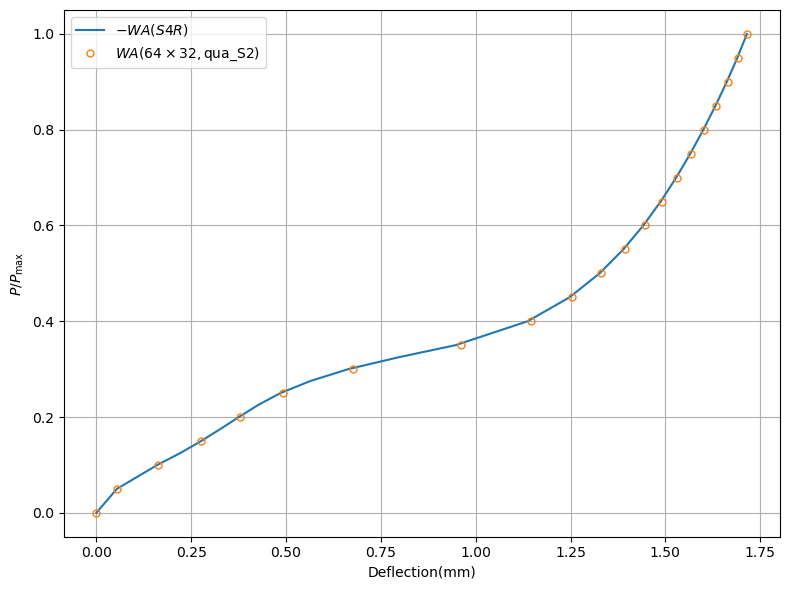

In [31]:
import matplotlib.pyplot as plt

if mesh.comm.rank == 0:
    WA_S4R = 1.e-2*np.array([0., 5.421, 16.1, 22.195, 27.657, 32.7, 37.582, 42.633,
        48.537, 56.355, 66.410, 79.810, 94.669, 113.704, 124.751, 132.653,
        138.920, 144.185, 148.770, 152.863, 156.584, 160.015, 163.211,
        166.200, 168.973, 171.505])
        
    P_S4R = np.array([0., .05, .1, .125, .15, .175, .2, .225, .25, .275, .3,
        .325, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1.])
    np.savetxt(results_folder/"PS_Pmax.txt", PS_list/PS_max)
    np.savetxt(results_folder/"WA.txt", u3_list)
    plt.figure(figsize=(8.0, 6.0))
    plt.plot(WA_S4R, P_S4R, "-", label="$-WA(S4R)$")
    plt.plot(-u3_list, PS_list / PS_max, "o", markersize=5, markerfacecolor='none',
             markevery = 2, label=f"$WA({nex}\\times{ney},${ele_type})")
    plt.xlabel("Deflection(mm)")
    plt.ylabel(r"$P/P_{\mathrm{max}}$")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(results_folder/"comparisons.png")

# References

[1] K. Sze, X. Liu, and S. Lo. Popular benchmark problems for geometric nonlinear analysis of shells. Finite Elements in Analysis and Design, 40(11):1551 – 1569, 2004.

[2] D. Arnold and F.Brezzi, Mathematics of Computation, 66(217): 1-14, 1997. https://www.ima.umn.edu/~arnold//papers/shellelt.pdf

[3] P. Betsch, A. Menzel, and E. Stein. On the parametrization of finite rotations in computational mechanics: A classification of concepts with application to smooth shells. Computer Methods in Applied Mechanics and Engineering, 155(3):273 – 305, 1998.

[4] https://fenicsproject.discourse.group/t/point-sources-redux/13496/4